![hybrid.jpg](https://github.com/ML-Response-Unit/recsys_pipes/blob/main/research/hybrid.jpg?raw=1)

In [268]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [269]:
import pandas as pd
import numpy as np
import plotly.express as px
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import Birch
from catboost import CatBoostRegressor
from catboost import CatBoostClassifier
from catboost import Pool


In [270]:
user_data = pd.read_csv("customers.csv").dropna()
actions_data = pd.read_csv("dataset.csv").dropna().astype(int)
cars_data = pd.read_csv("cars_about.csv").dropna()

## Preprocess user data

In [271]:
user_data

,customer_id,gender,married,age,graduated,profession,familySize
0,45,Male,No,22,No,Healthcare,4.0
1,817,Female,Yes,38,Yes,Engineer,3.0
2,495,Female,Yes,67,Yes,Engineer,1.0
3,36,Male,Yes,67,Yes,Lawyer,2.0
4,76,Female,Yes,40,Yes,Entertainment,6.0
...,...,...,...,...,...,...,...
315,353,Male,Yes,74,Yes,Lawyer,2.0
316,411,Female,No,30,No,Homemaker,4.0
317,297,Female,No,37,Yes,Artist,2.0
318,186,Female,No,22,No,Marketing,1.0


In [272]:
# Identify the categorical columns
cat_cols = ['gender', 'married', 'graduated', 'profession']

# Convert the categorical columns to numerical using Label Encoding
for col in cat_cols:
    le = LabelEncoder()
    user_data[col] = le.fit_transform(user_data[col])

user_data

,customer_id,gender,married,age,graduated,profession,familySize
0,45,1,0,22,0,5,4.0
1,817,0,1,38,1,2,3.0
2,495,0,1,67,1,2,1.0
3,36,1,1,67,1,7,2.0
4,76,0,1,40,1,3,6.0
...,...,...,...,...,...,...,...
315,353,1,1,74,1,7,2.0
316,411,0,0,30,0,6,4.0
317,297,0,0,37,1,0,2.0
318,186,0,0,22,0,8,1.0


## Preprocess cars data

In [273]:
cars_data = pd.read_csv("cars_about.csv").dropna()

cars_data["brand"] = cars_data.car_model.apply(lambda a: a.split()[0])
cars_data = cars_data.drop(columns=["car_model", "engine", "car_id"])
cars_data["price"] = cars_data['price'].apply(lambda a: int(a[1:]))

cars_data['used_label'] = cars_data["used_label"].apply(lambda a: 1 if a=="Used" else 0)
# Identify the categorical columns
car_cat_cols = ['exteriorColor', 'interiorColor', 'drivetrain', 'fuelType', 'transmission', 'brand']

# Convert the categorical columns to numerical using Label Encoding
for col in car_cat_cols:
    le = LabelEncoder()
    cars_data[col] = le.fit_transform(cars_data[col])

cars_data

,used_label,price,exteriorColor,interiorColor,drivetrain,minMPG,maxMPG,fuelType,transmission,mileage,brand
0,1,39,139,11,4,19.0,27.0,3,20,29403.0,28
1,1,49,145,11,3,19.0,24.0,3,2,32929.0,10
2,1,41,62,11,3,15.0,21.0,3,20,23173.0,25
3,1,28,66,83,4,29.0,35.0,3,28,10598.0,13
4,1,49,53,10,4,20.0,27.0,3,20,28137.0,19
...,...,...,...,...,...,...,...,...,...,...,...
399,1,33,46,11,3,18.0,25.0,3,20,43807.0,16
400,0,30,163,57,2,34.0,30.0,5,28,41944.0,28
401,1,35,11,11,2,22.0,29.0,3,24,49386.0,5
402,1,35,168,49,3,16.0,22.0,3,9,115795.0,6


## Preprocess actions data

In [274]:
actions_data = actions_data.rename(columns = {"item_id":"car_id"})

In [275]:
actions_pivot_table = pd.pivot_table(actions_data.sort_values(by="car_id"), values='interaction', index='user_id', columns='car_id').fillna(0)

In [276]:
actions_data.car_id.nunique()

109

In [277]:
px.imshow(actions_pivot_table)

In [278]:
actions_data = pd.melt(actions_pivot_table.reset_index(), id_vars='user_id', value_vars=actions_pivot_table.columns).rename(columns={"value":"interaction"})

In [279]:
actions_data.interaction.unique()

array([1, 0])

In [280]:
actions_data

,user_id,car_id,interaction
0,0,0,1
1,1,0,0
2,2,0,0
3,3,0,0
4,4,0,0
...,...,...,...
8170,70,402,0
8171,71,402,0
8172,72,402,0
8173,73,402,0


In [281]:
actions_data.interaction = actions_data.interaction.apply(lambda a: 1 if a > 0.5 else 0)

In [282]:
actions_data

,user_id,car_id,interaction
0,0,0,1
1,1,0,0
2,2,0,0
3,3,0,0
4,4,0,0
...,...,...,...
8170,70,402,0
8171,71,402,0
8172,72,402,0
8173,73,402,0


In [283]:
new_actions_pivot_table = pd.pivot_table(actions_data.sort_values(by="car_id"), values='interaction', index='user_id', columns='car_id').fillna(0)

In [284]:
px.imshow(new_actions_pivot_table)

## CatBoost inputs

1. собираю фичи топ n понравившихся авто
2. конкатенирую фичи понравившихся авто с таргет авто
3. делаю бинарную классификацию 

In [340]:
N_POSITIVE = 5

In [ ]:
column_names = []
cat_columns = ['used_label', 'exteriorColor', 'interiorColor', 'drivetrain', 'fuelType', 'transmission', 'brand']
cat_features = []

for index in range(N_POSITIVE):
    for column in cars_data.columns:
        column_names.append(f"car_{index}_{column}")
        
for column in cars_data.columns:
    column_names.append(f"target_{column}")

for column in column_names:
    for c_column in cat_columns:
        if c_column in column:
            cat_features.append(column)
        
dataset = pd.DataFrame(columns=column_names + ["interaction"])

for user_id in actions_data.user_id.unique():
    for target_car_id in actions_data.car_id.unique():
        # len(cars_data.columns) * (N_POSITIVE + 1))
        matrix_features = []
        features = []
        current_positive_samples = actions_data.query(f"user_id == {user_id}").query(f"car_id != {target_car_id}").query("interaction == 1")
        # print()
        if len(current_positive_samples) < N_POSITIVE: continue

        for car_id in current_positive_samples.sample(N_POSITIVE).car_id.to_list():
            matrix_features.append(cars_data.iloc[car_id].to_list())
        matrix_features.append(cars_data.iloc[target_car_id].to_list())
        matrix_features.append(int(actions_data.loc[actions_data.car_id == target_car_id].query(f"user_id == {user_id}").interaction))
        
        for item in matrix_features:
            if isinstance(item, list):
                for elem in item:
                    features.append(elem)
            else:
                features.append(item)
        # print(features)
        dataset = pd.concat([dataset, pd.DataFrame.from_records([dict(zip(dataset.columns, features))])])

# dataset = dataset.astype(int)

In [287]:
dataset

,car_0_used_label,car_0_price,car_0_exteriorColor,car_0_interiorColor,car_0_drivetrain,car_0_minMPG,car_0_maxMPG,car_0_fuelType,car_0_transmission,car_0_mileage,...,target_exteriorColor,target_interiorColor,target_drivetrain,target_minMPG,target_maxMPG,target_fuelType,target_transmission,target_mileage,target_brand,interaction
0,1.0,28.0,174.0,27.0,3.0,16.0,22.0,3.0,9.0,139597.0,...,139.0,11.0,4.0,19.0,27.0,3.0,20.0,29403.0,28.0,1
0,1.0,35.0,168.0,49.0,3.0,16.0,22.0,3.0,9.0,115795.0,...,62.0,11.0,3.0,15.0,21.0,3.0,20.0,23173.0,25.0,0
0,1.0,18.0,85.0,68.0,5.0,21.0,30.0,3.0,15.0,58157.0,...,66.0,83.0,4.0,29.0,35.0,3.0,28.0,10598.0,13.0,0
0,1.0,42.0,76.0,74.0,5.0,19.0,28.0,3.0,20.0,10236.0,...,53.0,10.0,4.0,20.0,27.0,3.0,20.0,28137.0,19.0,0
0,1.0,42.0,76.0,74.0,5.0,19.0,28.0,3.0,20.0,10236.0,...,11.0,83.0,5.0,17.0,23.0,3.0,6.0,105469.0,28.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,1.0,36.0,114.0,44.0,4.0,20.0,27.0,3.0,20.0,47729.0,...,49.0,44.0,4.0,20.0,26.0,3.0,20.0,24793.0,17.0,1
0,1.0,44.0,131.0,8.0,2.0,19.0,26.0,3.0,24.0,14445.0,...,11.0,11.0,2.0,21.0,28.0,3.0,24.0,10769.0,22.0,0
0,0.0,46.0,167.0,11.0,5.0,15.0,24.0,3.0,20.0,25642.0,...,56.0,35.0,2.0,19.0,26.0,3.0,20.0,22492.0,10.0,0
0,1.0,16.0,66.0,11.0,5.0,19.0,28.0,3.0,9.0,48605.0,...,90.0,25.0,4.0,26.0,33.0,3.0,28.0,23320.0,23.0,0


In [288]:
dataset.shape

(7836, 45)

In [289]:
dataset.interaction.value_counts()

0    7282
1     554
Name: interaction, dtype: int64

In [290]:
dataset

,car_0_used_label,car_0_price,car_0_exteriorColor,car_0_interiorColor,car_0_drivetrain,car_0_minMPG,car_0_maxMPG,car_0_fuelType,car_0_transmission,car_0_mileage,...,target_exteriorColor,target_interiorColor,target_drivetrain,target_minMPG,target_maxMPG,target_fuelType,target_transmission,target_mileage,target_brand,interaction
0,1.0,28.0,174.0,27.0,3.0,16.0,22.0,3.0,9.0,139597.0,...,139.0,11.0,4.0,19.0,27.0,3.0,20.0,29403.0,28.0,1
0,1.0,35.0,168.0,49.0,3.0,16.0,22.0,3.0,9.0,115795.0,...,62.0,11.0,3.0,15.0,21.0,3.0,20.0,23173.0,25.0,0
0,1.0,18.0,85.0,68.0,5.0,21.0,30.0,3.0,15.0,58157.0,...,66.0,83.0,4.0,29.0,35.0,3.0,28.0,10598.0,13.0,0
0,1.0,42.0,76.0,74.0,5.0,19.0,28.0,3.0,20.0,10236.0,...,53.0,10.0,4.0,20.0,27.0,3.0,20.0,28137.0,19.0,0
0,1.0,42.0,76.0,74.0,5.0,19.0,28.0,3.0,20.0,10236.0,...,11.0,83.0,5.0,17.0,23.0,3.0,6.0,105469.0,28.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,1.0,36.0,114.0,44.0,4.0,20.0,27.0,3.0,20.0,47729.0,...,49.0,44.0,4.0,20.0,26.0,3.0,20.0,24793.0,17.0,1
0,1.0,44.0,131.0,8.0,2.0,19.0,26.0,3.0,24.0,14445.0,...,11.0,11.0,2.0,21.0,28.0,3.0,24.0,10769.0,22.0,0
0,0.0,46.0,167.0,11.0,5.0,15.0,24.0,3.0,20.0,25642.0,...,56.0,35.0,2.0,19.0,26.0,3.0,20.0,22492.0,10.0,0
0,1.0,16.0,66.0,11.0,5.0,19.0,28.0,3.0,9.0,48605.0,...,90.0,25.0,4.0,26.0,33.0,3.0,28.0,23320.0,23.0,0


In [ ]:
balanced_dataset = pd.concat([dataset.loc[dataset.interaction == 1], dataset.loc[dataset.interaction == 0].sample(int(dataset.interaction.value_counts()[1] * 1.5))])

In [292]:
balanced_dataset

,car_0_used_label,car_0_price,car_0_exteriorColor,car_0_interiorColor,car_0_drivetrain,car_0_minMPG,car_0_maxMPG,car_0_fuelType,car_0_transmission,car_0_mileage,...,target_exteriorColor,target_interiorColor,target_drivetrain,target_minMPG,target_maxMPG,target_fuelType,target_transmission,target_mileage,target_brand,interaction
0,1.0,28.0,174.0,27.0,3.0,16.0,22.0,3.0,9.0,139597.0,...,139.0,11.0,4.0,19.0,27.0,3.0,20.0,29403.0,28.0,1
0,1.0,42.0,76.0,74.0,5.0,19.0,28.0,3.0,20.0,10236.0,...,11.0,83.0,5.0,17.0,23.0,3.0,6.0,105469.0,28.0,1
0,1.0,5.0,165.0,76.0,4.0,23.0,23.0,3.0,27.0,204440.0,...,85.0,68.0,5.0,21.0,30.0,3.0,15.0,58157.0,22.0,1
0,1.0,23.0,173.0,8.0,2.0,18.0,27.0,3.0,9.0,99697.0,...,167.0,11.0,5.0,15.0,24.0,3.0,20.0,25642.0,8.0,1
0,1.0,5.0,165.0,76.0,4.0,23.0,23.0,3.0,27.0,204440.0,...,76.0,74.0,5.0,19.0,28.0,3.0,20.0,10236.0,19.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,1.0,122.0,173.0,81.0,2.0,80.0,77.0,2.0,0.0,29918.0,...,99.0,63.0,3.0,17.0,20.0,3.0,6.0,16854.0,28.0,0
0,1.0,25.0,180.0,83.0,5.0,15.0,22.0,0.0,9.0,135228.0,...,66.0,11.0,4.0,22.0,29.0,3.0,9.0,21055.0,17.0,0
0,1.0,52.0,110.0,64.0,2.0,23.0,28.0,3.0,16.0,14222.0,...,19.0,20.0,2.0,0.0,0.0,6.0,33.0,10500.0,3.0,0
0,1.0,20.0,2.0,44.0,4.0,21.0,34.0,3.0,9.0,73467.0,...,173.0,11.0,2.0,18.0,23.0,3.0,16.0,38729.0,24.0,0


In [293]:
balanced_dataset.interaction.value_counts()

0    831
1    554
Name: interaction, dtype: int64

In [294]:
dataset.columns

Index(['car_0_used_label', 'car_0_price', 'car_0_exteriorColor',
       'car_0_interiorColor', 'car_0_drivetrain', 'car_0_minMPG',
       'car_0_maxMPG', 'car_0_fuelType', 'car_0_transmission', 'car_0_mileage',
       'car_0_brand', 'car_1_used_label', 'car_1_price', 'car_1_exteriorColor',
       'car_1_interiorColor', 'car_1_drivetrain', 'car_1_minMPG',
       'car_1_maxMPG', 'car_1_fuelType', 'car_1_transmission', 'car_1_mileage',
       'car_1_brand', 'car_2_used_label', 'car_2_price', 'car_2_exteriorColor',
       'car_2_interiorColor', 'car_2_drivetrain', 'car_2_minMPG',
       'car_2_maxMPG', 'car_2_fuelType', 'car_2_transmission', 'car_2_mileage',
       'car_2_brand', 'target_used_label', 'target_price',
       'target_exteriorColor', 'target_interiorColor', 'target_drivetrain',
       'target_minMPG', 'target_maxMPG', 'target_fuelType',
       'target_transmission', 'target_mileage', 'target_brand', 'interaction'],
      dtype='object')

In [295]:
cat_features

['car_0_used_label',
 'car_0_exteriorColor',
 'car_0_interiorColor',
 'car_0_drivetrain',
 'car_0_fuelType',
 'car_0_transmission',
 'car_0_brand',
 'car_1_used_label',
 'car_1_exteriorColor',
 'car_1_interiorColor',
 'car_1_drivetrain',
 'car_1_fuelType',
 'car_1_transmission',
 'car_1_brand',
 'car_2_used_label',
 'car_2_exteriorColor',
 'car_2_interiorColor',
 'car_2_drivetrain',
 'car_2_fuelType',
 'car_2_transmission',
 'car_2_brand',
 'target_used_label',
 'target_exteriorColor',
 'target_interiorColor',
 'target_drivetrain',
 'target_fuelType',
 'target_transmission',
 'target_brand']

In [ ]:
from sklearn.model_selection import train_test_split
# Split into training and validation sets
train_df, val_df = train_test_split(balanced_dataset.astype(int), test_size=0.2, random_state=42)
X_train, y_train = train_df.drop(columns=['interaction']), train_df[["interaction"]]

# Split into validation and test sets
val_df, test_df = train_test_split(val_df, test_size=0.2, random_state=42)

X_val, y_val = val_df.drop(columns=['interaction']), val_df[["interaction"]]
X_test, y_test = test_df.drop(columns=['interaction']), test_df[["interaction"]]

In [297]:
X_train.shape, X_val.shape, X_test.shape

((1108, 44), (221, 44), (56, 44))

In [298]:
X_train

,car_0_used_label,car_0_price,car_0_exteriorColor,car_0_interiorColor,car_0_drivetrain,car_0_minMPG,car_0_maxMPG,car_0_fuelType,car_0_transmission,car_0_mileage,...,target_price,target_exteriorColor,target_interiorColor,target_drivetrain,target_minMPG,target_maxMPG,target_fuelType,target_transmission,target_mileage,target_brand
0,1,43,132,83,4,25,34,3,21,10732,...,122,173,81,2,80,77,2,0,29918,27
0,1,14,36,66,5,18,25,3,9,90908,...,33,111,65,2,22,27,3,16,43496,2
0,1,107,11,11,3,14,19,3,2,28000,...,40,45,83,2,20,27,3,20,10969,30
0,1,20,158,83,5,20,29,3,15,102893,...,42,180,83,2,19,26,3,24,15002,13
0,0,38,120,56,4,19,28,3,24,14494,...,37,124,61,2,21,27,3,2,18576,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,1,72,173,83,5,18,25,3,32,6626,...,33,90,25,4,26,33,3,28,23320,23
0,1,36,114,44,4,20,27,3,20,47729,...,31,88,37,3,16,22,3,9,47661,10
0,1,25,180,83,5,15,22,0,9,135228,...,58,79,11,2,20,26,3,20,31750,3
0,1,25,180,83,5,15,22,0,9,135228,...,52,110,64,2,23,28,3,16,14222,2


In [299]:
y_train

,interaction
0,0
0,0
0,0
0,0
0,0
...,...
0,0
0,0
0,0
0,0


In [300]:
# Create CatBoost model
model = CatBoostRegressor(iterations=1000, 
                           learning_rate=0.05, 
                           # depth=5, 
                        #    loss_function='CrossEntropy', 
                           cat_features=cat_features, 
                           random_seed=42)

# Fit the model on the training data
model.fit(X_train, y_train, 
          eval_set=(X_val, y_val), 
          early_stopping_rounds=50, 
          verbose=1)

# Make predictions on the test data
y_pred = model.predict(X_test)
y_pred

0:	learn: 0.4867604	test: 0.4800210	best: 0.4800210 (0)	total: 13.7ms	remaining: 13.6s
1:	learn: 0.4820122	test: 0.4752416	best: 0.4752416 (1)	total: 26.6ms	remaining: 13.3s
2:	learn: 0.4780195	test: 0.4704673	best: 0.4704673 (2)	total: 40ms	remaining: 13.3s
3:	learn: 0.4740386	test: 0.4654575	best: 0.4654575 (3)	total: 52.2ms	remaining: 13s
4:	learn: 0.4696801	test: 0.4604710	best: 0.4604710 (4)	total: 63ms	remaining: 12.5s
5:	learn: 0.4667615	test: 0.4567387	best: 0.4567387 (5)	total: 72.5ms	remaining: 12s
6:	learn: 0.4635855	test: 0.4528312	best: 0.4528312 (6)	total: 77.5ms	remaining: 11s
7:	learn: 0.4605133	test: 0.4489999	best: 0.4489999 (7)	total: 88.9ms	remaining: 11s
8:	learn: 0.4580166	test: 0.4469796	best: 0.4469796 (8)	total: 99.7ms	remaining: 11s
9:	learn: 0.4554258	test: 0.4437784	best: 0.4437784 (9)	total: 110ms	remaining: 10.9s
10:	learn: 0.4529915	test: 0.4408268	best: 0.4408268 (10)	total: 121ms	remaining: 10.9s
11:	learn: 0.4503555	test: 0.4381627	best: 0.4381627 (11)

array([ 0.21811224,  0.4278793 ,  0.11766454,  0.60122603, -0.02218873,
        0.64205031,  0.23638563,  0.6449894 ,  0.79084294,  0.20168751,
        0.7160157 ,  0.69920964,  0.7440137 ,  0.22739637,  0.68977519,
        0.22003614,  0.11285076,  0.68055407,  0.30641316,  0.7737716 ,
        0.10932998,  0.13498922,  0.11788138,  0.3201959 ,  0.56784555,
        0.14669005,  0.76089075,  0.09658438,  0.59622516,  0.01494904,
        0.68696594,  0.19526217,  0.05946811,  0.6920763 ,  0.64387322,
        0.42349615,  0.37957969,  0.23292117,  0.12304545,  0.10141283,
        0.54840859,  0.12905331,  0.19513602,  0.65151199,  0.69800709,
        0.19699788,  0.30166083,  0.27401894,  0.09912151,  0.50705352,
        0.41023752,  0.03730034,  0.24477017,  0.32627632,  0.13176697,
        0.50817651])

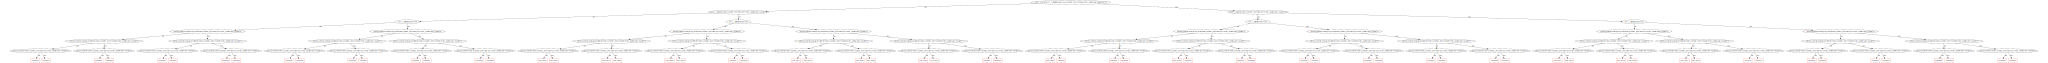

In [301]:
pool = Pool(X_test, y_test, cat_features=cat_features, feature_names=list(X_test.columns))
model.plot_tree(
    tree_idx=0,
    pool=pool
)


In [302]:
# Create CatBoost model
model = CatBoostClassifier(iterations=1000, 
                           learning_rate=0.05, 
                        #    depth=5, 
                           loss_function='CrossEntropy', 
                           cat_features=cat_features, 
                           random_seed=42)

# Fit the model on the training data
model.fit(X_train, y_train, 
          eval_set=(X_val, y_val), 
          early_stopping_rounds=50, 
          verbose=100)

# Make predictions on the test data
y_pred = model.predict(X_test)

0:	learn: 0.6801661	test: 0.6769223	best: 0.6769223 (0)	total: 15.3ms	remaining: 15.3s
100:	learn: 0.4398093	test: 0.5133717	best: 0.5133717 (100)	total: 1.24s	remaining: 11s
200:	learn: 0.3289570	test: 0.5003552	best: 0.5003552 (200)	total: 3.27s	remaining: 13s
300:	learn: 0.2508123	test: 0.4997941	best: 0.4964209 (287)	total: 6.28s	remaining: 14.6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.4964209433
bestIteration = 287

Shrink model to first 288 iterations.


In [303]:
submission_table = pd.DataFrame(dict(gt = y_test.interaction, pred = y_pred))

In [304]:
submission_table

,gt,pred
0,0,0
0,0,0
0,1,0
0,1,1
0,0,0
0,1,1
0,0,0
0,0,1
0,1,1
0,0,0


In [305]:
n_correct = 0
for i in range(len(submission_table)):
    current_row = list(submission_table.iloc[i])
    if current_row[0] == current_row[1]:
        n_correct += 1
print(f"test accurracy: {n_correct/len(y_test)}")

test accurracy: 0.7142857142857143


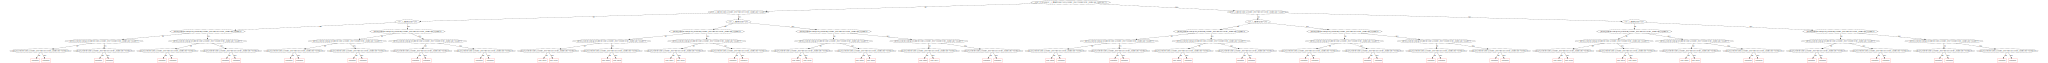

In [306]:
pool = Pool(X_test, y_test, cat_features=cat_features, feature_names=list(X_test.columns))
model.plot_tree(
    tree_idx=0,
    pool=pool
)


## Linear Layers Stack

In [307]:
torch.from_numpy(np.array(X_train)), torch.from_numpy(np.array(y_train))

(tensor([[     1,     43,    132,  ...,      0,  29918,     27],
         [     1,     14,     36,  ...,     16,  43496,      2],
         [     1,    107,     11,  ...,     20,  10969,     30],
         ...,
         [     1,     25,    180,  ...,     20,  31750,      3],
         [     1,     25,    180,  ...,     16,  14222,      2],
         [     0,     46,    167,  ...,      6, 151989,     28]]),
 tensor([[0],
         [0],
         [0],
         ...,
         [0],
         [0],
         [0]]))

In [308]:
def normalize(x):
    x_normed = x / x.max(0, keepdims=True)[0]
    return x_normed

In [309]:
X_train.values.max(0, keepdims=True)

array([[     1,    122,    180,     83,      5,    131,    117,      6,
            36, 204440,     30,      1,    122,    180,     83,      5,
           131,    117,      6,     36, 213000,     30,      1,    122,
           180,     83,      5,    131,    117,      6,     36, 213000,
            30,      1,    122,    180,     83,      5,    131,    117,
             6,     36, 213000,     30]])

In [320]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the neural network
class MultiLayerNet(nn.Module):
    def __init__(self):
        super(MultiLayerNet, self).__init__()
        self.layer1 = nn.Linear(44, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        out = self.layer1(x)
        out = nn.functional.relu(out)
        out = self.layer2(out)
        out = nn.functional.relu(out)
        out = self.layer3(out)
        out = self.sigmoid(out)
        return out

# Instantiate the neural network
net = MultiLayerNet()

# Define the loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Load the dataset

X_test_tensor = normalize(torch.from_numpy(np.array(X_val)))
y_test_tensor = torch.from_numpy(np.array(y_val)).float()

X_train_tensor = normalize(torch.from_numpy(np.array(X_train)))
y_train_tensor = torch.from_numpy(np.array(y_train)).float()

epochs = 5000
# Train the neural network
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = net(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    # Print the loss every 10 epochs
    if (epoch+1) % 10 == 0:
        print('Epoch [%d/%d], Loss: %.4f' % (epoch+1, epochs, loss.item()))


Epoch [10/5000], Loss: 0.6766
Epoch [20/5000], Loss: 0.6741
Epoch [30/5000], Loss: 0.6700
Epoch [40/5000], Loss: 0.6640
Epoch [50/5000], Loss: 0.6549
Epoch [60/5000], Loss: 0.6434
Epoch [70/5000], Loss: 0.6313
Epoch [80/5000], Loss: 0.6192
Epoch [90/5000], Loss: 0.6063
Epoch [100/5000], Loss: 0.5922
Epoch [110/5000], Loss: 0.5773
Epoch [120/5000], Loss: 0.5609
Epoch [130/5000], Loss: 0.5438
Epoch [140/5000], Loss: 0.5259
Epoch [150/5000], Loss: 0.5069
Epoch [160/5000], Loss: 0.4868
Epoch [170/5000], Loss: 0.4676
Epoch [180/5000], Loss: 0.4485
Epoch [190/5000], Loss: 0.4310
Epoch [200/5000], Loss: 0.4135
Epoch [210/5000], Loss: 0.3978
Epoch [220/5000], Loss: 0.3825
Epoch [230/5000], Loss: 0.3689
Epoch [240/5000], Loss: 0.3545
Epoch [250/5000], Loss: 0.3416
Epoch [260/5000], Loss: 0.3297
Epoch [270/5000], Loss: 0.3191
Epoch [280/5000], Loss: 0.3072
Epoch [290/5000], Loss: 0.2969
Epoch [300/5000], Loss: 0.2874
Epoch [310/5000], Loss: 0.2781
Epoch [320/5000], Loss: 0.2686
Epoch [330/5000],

In [335]:
with torch.no_grad():
    outputs = net(X_train_tensor)

In [336]:
sub = pd.DataFrame(dict(GT=y_train.interaction, pred = list(int(x) for x in outputs)))
sub

,GT,pred
0,0,0
0,0,0
0,0,0
0,0,0
0,0,0
...,...,...
0,0,0
0,0,0
0,0,0
0,0,0


In [339]:
f"accuracy: {sum(sub.GT == sub.pred) / len(sub)}"

'accuracy: 0.6922382671480144'

In [324]:
list(int(x) for x in outputs)

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
